<a href="https://colab.research.google.com/github/pdoren/Machine-Learning-G105/blob/main/Desaf%C3%ADo_2_Segmentaci%C3%B3n_de_Clientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío 2- Segmentación de Clientes

**Nombre**: Pablo Saavedra <br />
**Curso**: Machine Learning (G105)


---

## 1. Procesador la base de datos

Leer el archivo Retail_Invoices.xlsx y realizar un análisis de calidad de datos, para definir la calidad de la data entregada considerando valores anómalos, valores faltantes, etc. Limpia lo que sea necesario y realiza un análisis exploratorio de los datos considerando gráficos de distribuciones y correlaciones entre estos.

### Importación de librerías

In [ ]:
!pip install scikit-fuzzy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import scipy.stats as st
import math
import statsmodels.api as sm
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from skfuzzy.cluster import cmeans

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score, davies_bouldin_score

pd.options.display.float_format = "{:,.2f}".format   # Visualizar 2 decimales

### Carga de datos

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Retail_Invoices.xlsx')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22190 entries, 0 to 22189
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    22190 non-null  object        
 1   InvoiceDate  22190 non-null  datetime64[ns]
 2   CustomerID   22190 non-null  int64         
 3   Quantity     22190 non-null  int64         
 4   price_total  22190 non-null  float64       
 5   StockCode    22190 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.0+ MB


In [ ]:
df.head()

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
0,536365,2010-12-01,17850,40,139.12,7
1,536366,2010-12-01,17850,12,22.20,2
2,536367,2010-12-01,13047,83,278.73,12
3,536368,2010-12-01,13047,15,70.05,4
4,536369,2010-12-01,13047,3,17.85,1


### Análisis

In [ ]:
print(f"Número de registros nulos:\n{df.isnull().sum()}")
print(f"Número de registros NaN:\n{df.isna().sum()}")

Número de registros nulos:
InvoiceNo      0
InvoiceDate    0
CustomerID     0
Quantity       0
price_total    0
StockCode      0
dtype: int64
Número de registros NaN:
InvoiceNo      0
InvoiceDate    0
CustomerID     0
Quantity       0
price_total    0
StockCode      0
dtype: int64


> No existen registros nulos

In [ ]:
df.describe()

,InvoiceDate,CustomerID,Quantity,price_total,StockCode
count,22190,"22,190.00","22,190.00","22,190.00","22,190.00"
mean,2011-06-29 05:59:15.223073536,"15,238.50",221.13,374.05,18.33
min,2010-12-01 00:00:00,"12,346.00","-80,995.00","-168,469.60",1.00
25%,2011-03-29 00:00:00,"13,755.00",30.00,87.96,3.00
50%,2011-07-08 00:00:00,"15,136.00",120.00,241.50,12.00
75%,2011-10-10 00:00:00,"16,746.00",254.00,418.02,24.00
max,2011-12-09 00:00:00,"18,287.00","80,995.00","168,469.60",542.00
std,NaN,"1,733.15","1,170.22","2,018.48",23.89


> Existen registros invalidos o incongruentes relacionados con la cantidad y precios. Los valores de las columnas Quantity y price_total deberían ser positivos, **para este análisis se eliminaran los valores negativos**

In [ ]:
# eliminar registros negativos en columna Quantity y price_total
df = df[(df['Quantity'] >= 0) & (df['price_total'] >= 0)]

df.describe()

,InvoiceDate,CustomerID,Quantity,price_total,StockCode
count,18536,"18,536.00","18,536.00","18,536.00","18,536.00"
mean,2011-07-01 03:51:21.053085952,"15,266.22",279.55,480.76,21.47
min,2010-12-01 00:00:00,"12,346.00",1.00,0.00,1.00
25%,2011-03-30 00:00:00,"13,773.50",74.00,157.93,6.00
50%,2011-07-12 00:00:00,"15,176.50",155.00,303.02,15.00
75%,2011-10-12 00:00:00,"16,779.00",291.00,471.66,28.00
max,2011-12-09 00:00:00,"18,287.00","80,995.00","168,469.60",542.00
std,NaN,"1,734.18",976.80,"1,678.03",24.92


In [ ]:
print(f"Número de registros: {len(df)}")
print(f"Número de clientes diferentes: {len(df['CustomerID'].unique())}")
print(f"Número de productos diferentes: {len(df['StockCode'].unique())}")
print(f"Rango de fechas: {df['InvoiceDate'].min()} | {df['InvoiceDate'].max()}")
print(f"Rango de precios: ${df['price_total'].min():,.2f} | ${df['price_total'].max():,.2f}")


Número de registros: 18536
Número de clientes diferentes: 4339
Número de productos diferentes: 199
Rango de fechas: 2010-12-01 00:00:00 | 2011-12-09 00:00:00
Rango de precios: $0.00 | $168,469.60


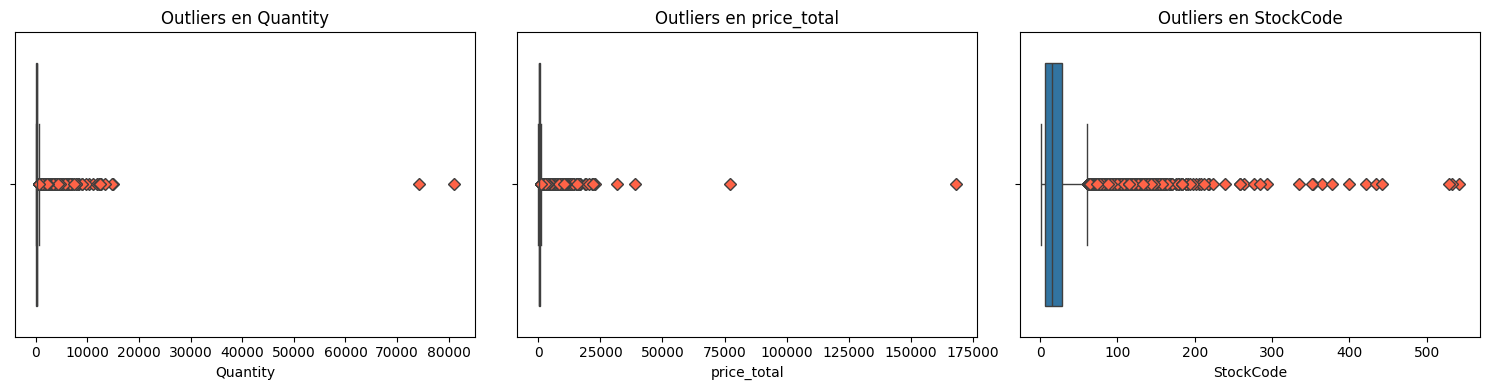

In [ ]:
variables_cuantitativas = ['Quantity', 'price_total', 'StockCode']

def plot_outliers(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))

  if isinstance(axes, np.ndarray):
      axes = axes.ravel()
  else:
      axes = np.array([axes])

  for i, col in enumerate(_num_cols):
      sns.boxplot(x=_df[col], flierprops = {'markerfacecolor':'tomato', 'marker':'D'}, ax=axes[i])
      axes[i].set_title(f"Outliers en {col}")
      axes[i].set_xlabel(col)

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

plot_outliers(df, variables_cuantitativas)


Existen varios outliers, se procedera a eliminarlos

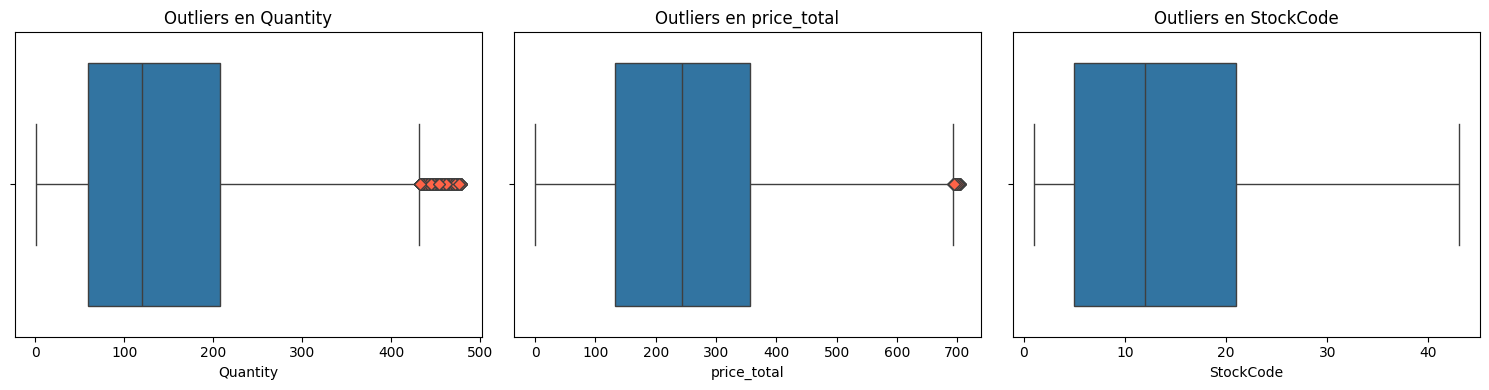

In [ ]:
def clean_outliers(_df: pd.DataFrame, _cols: list, _k: float=1.5):
  df_ret = _df.copy()
  for col in _cols:
    while True:
      q1, q3 = df_ret[col].quantile([.25, .75])
      iqr = q3 - q1
      low, high = q1 - _k * iqr, q3 + _k * iqr
      mask_out = (df_ret[col] < low) | (df_ret[col] > high)
      if mask_out.any():
        df_ret = df_ret[~mask_out]
      else:
        break
  return df_ret

df_limpio = clean_outliers(df, variables_cuantitativas)

plot_outliers(df_limpio, variables_cuantitativas)

In [ ]:
def plot_hist(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  for i, col in enumerate(_num_cols):
      sns.histplot(data=_df[col], kde=False, stat='density', ax=axes[i])
      sns.kdeplot(data=_df[col], color='tomato', lw=3, ax=axes[i])
      axes[i].set_title(f"Distribución de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

Distribución de variables sin limpieza de datos

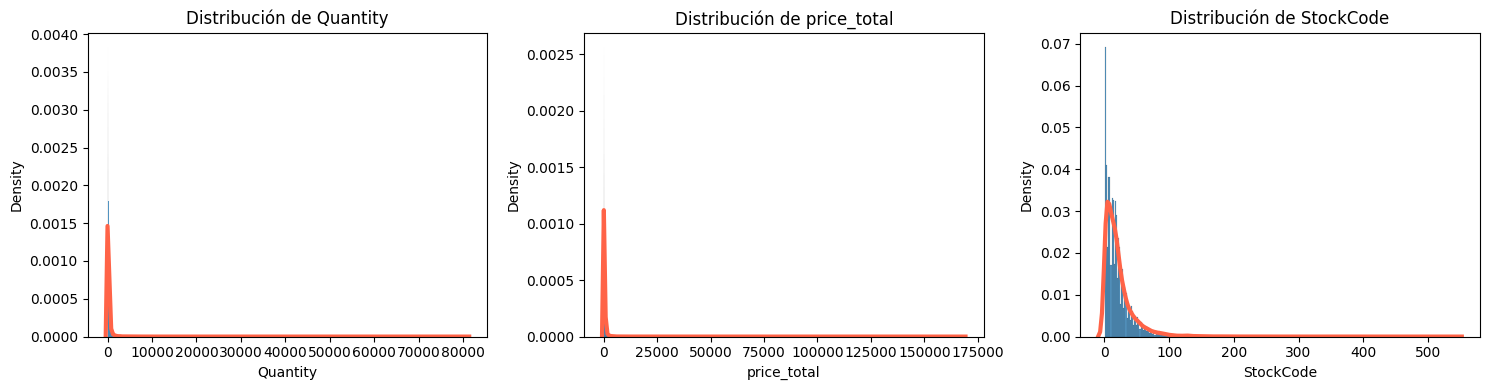

In [ ]:
plot_hist(df, variables_cuantitativas)

Distribución de variables con datos limpios (sin outliers)

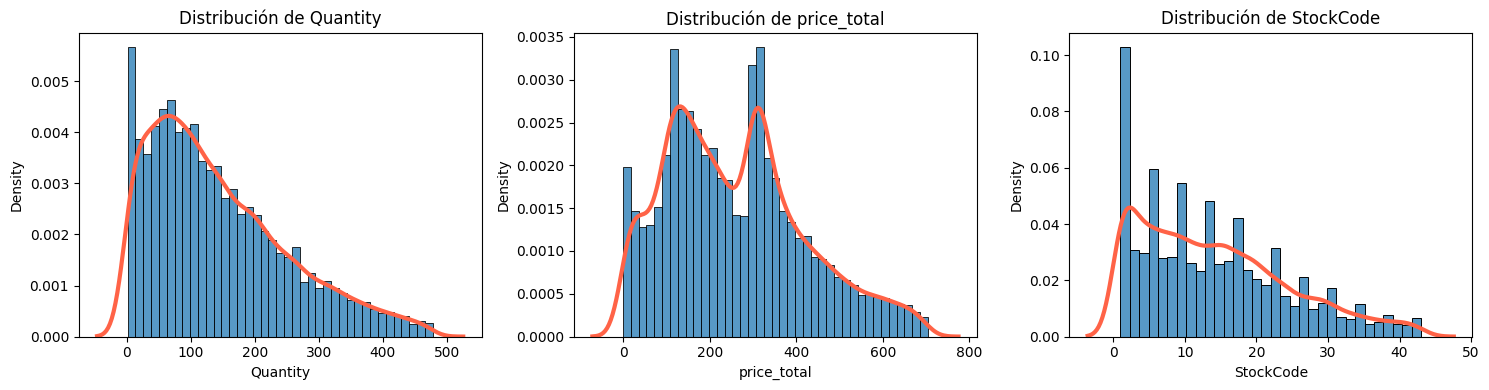

In [ ]:
plot_hist(df_limpio, variables_cuantitativas)

In [ ]:
n_eliminados = len(df) - len(df_limpio)
print(f"Número de registros eliminados: {n_eliminados} ({n_eliminados*100.0/len(df):.2f}% del total)")

Número de registros eliminados: 4274 (23.06% del total)


Correlaciones datos sin limpiar (con outliers)

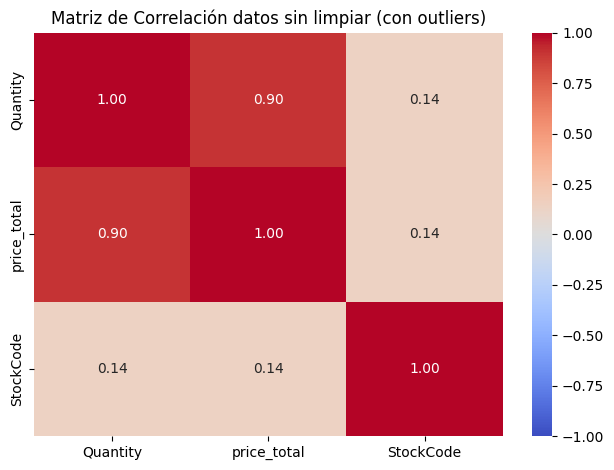

In [ ]:
matriz_correlacion = df[variables_cuantitativas].select_dtypes(include="number").corr()

sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm", fmt=".2f",vmin=-1, vmax=1)
plt.title("Matriz de Correlación datos sin limpiar (con outliers)")

plt.tight_layout()
plt.show()

Correlaciones datos limpios (sin outliers)

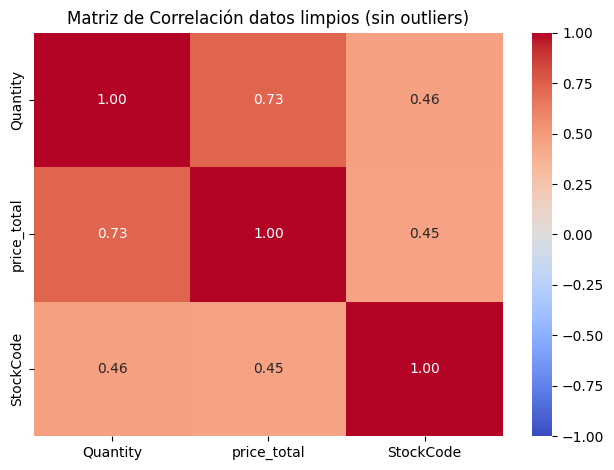

In [ ]:
matriz_correlacion = df_limpio[variables_cuantitativas].select_dtypes(include="number").corr()

sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm", fmt=".2f",vmin=-1, vmax=1)
plt.title("Matriz de Correlación datos limpios (sin outliers)")

plt.tight_layout()
plt.show()

Al revisar las correlaciones entre los datos con y sin outliers se puede concluir:

1. Los datos sin limpiar presentan una alta correlación entre precio y cantidad, lo esperable, a más productos mayor precio. Pero la correlación entre la cantidad de productos diferentes es pequeña a diferencia de los datos sin outliers.
2. Los datos sin outliers bajan en correlación entre cantidad y precio total, pero aumentan en cantidad de productos diferentes.
3. Se puede inferir que los outliers corresponden a productos muy caros en compras de pocos o solo un producto diferente.

### 2. Nuevas variables

Generar variables para la segmentación. Notar que la granularidad de la data es por boleta y se necesita segmentar clientes, por lo que es necesario generar variables a nivel de clientes. Se propone generar al menos RFM (Recencia, frecuencia y monto).

In [ ]:
fecha_ref = datetime(2025, 10, 31)
df_limpio["YearMonth"] = df_limpio["InvoiceDate"].dt.to_period("M")
meses_por_cliente = (
    df_limpio.groupby("CustomerID")["YearMonth"]
    .nunique()
    .rename("meses_unicos")
)

df_clientes = df_limpio.groupby("CustomerID").agg({
    "InvoiceDate": [lambda x: (fecha_ref - x.max()).days, lambda x: (fecha_ref - x.min()).days],  # Recency, Antiguedad cliente
    "CustomerID": "count",                                # Frequency
    "price_total": ["sum", "mean", "max", "min"],         # Monetary + stat
    "StockCode": ["sum", "mean", "max", "min"],
    "Quantity": ["sum", "mean", "max", "min"],
})

df_clientes.columns = [
    "_".join(col).strip() if isinstance(col, tuple) else col
    for col in df_clientes.columns.values
]

df_clientes = df_clientes.rename(columns={
    "InvoiceDate_<lambda_0>": "Recency",
    "InvoiceDate_<lambda_1>": "Antiguedad",
    "CustomerID_count": "Frequency",
    "price_total_sum": "Monetary"
})

df_clientes = df_clientes.join(meses_por_cliente)

# promedio de compras por mes
df_clientes["Frequency_mean_month"] = df_clientes["Frequency"] / df_clientes["meses_unicos"]

# Monto promedio
df_clientes["Monetary_mean"] = df_clientes["Monetary"] / df_clientes["Frequency"]

# Gasto promedio mensual
df_clientes["Monetary_mean_month"] = df_clientes["Monetary"] / df_clientes["meses_unicos"]

# Recencia relativa
df_clientes["Recency_rel"] = df_clientes["Recency"] / df_clientes["Antiguedad"]

# Radio del ticket
df_clientes["Ticket_rel"] = df_clientes["price_total_max"] / df_clientes["price_total_min"]

df_clientes.drop(columns=['meses_unicos'], inplace=True)

df_clientes.head()

,Recency,Antiguedad,Frequency,Monetary,price_total_mean,price_total_max,price_total_min,StockCode_sum,StockCode_mean,StockCode_max,StockCode_min,Quantity_sum,Quantity_mean,Quantity_max,Quantity_min,Frequency_mean_month,Monetary_mean,Monetary_mean_month,Recency_rel,Ticket_rel
CustomerID,,,,,,,,,,,,,,,,,,,,
12347,5077,5392,4,"1,667.64",416.91,584.91,224.82,80,20.00,29,11,980,245.00,315,192,1.00,416.91,416.91,0.94,2.60
12348,5150,5323,2,677.00,338.50,367.00,310.00,8,4.00,5,3,486,243.00,269,217,1.00,338.50,338.50,0.97,1.18
12350,5385,5385,1,334.40,334.40,334.40,334.40,17,17.00,17,17,197,197.00,197,197,1.00,334.40,334.40,1.00,1.00
12352,5111,5371,7,"1,665.74",237.96,366.25,120.33,82,11.71,18,5,533,76.14,127,26,1.75,237.96,416.44,0.95,3.04
12353,5279,5279,1,89.00,89.00,89.00,89.00,4,4.00,4,4,20,20.00,20,20,1.00,89.00,89.00,1.00,1.00


### Análisis de nuevas variables

Realizar un análisis exploratorio y las transformaciones necesarias a las nuevas variables.

Outliers

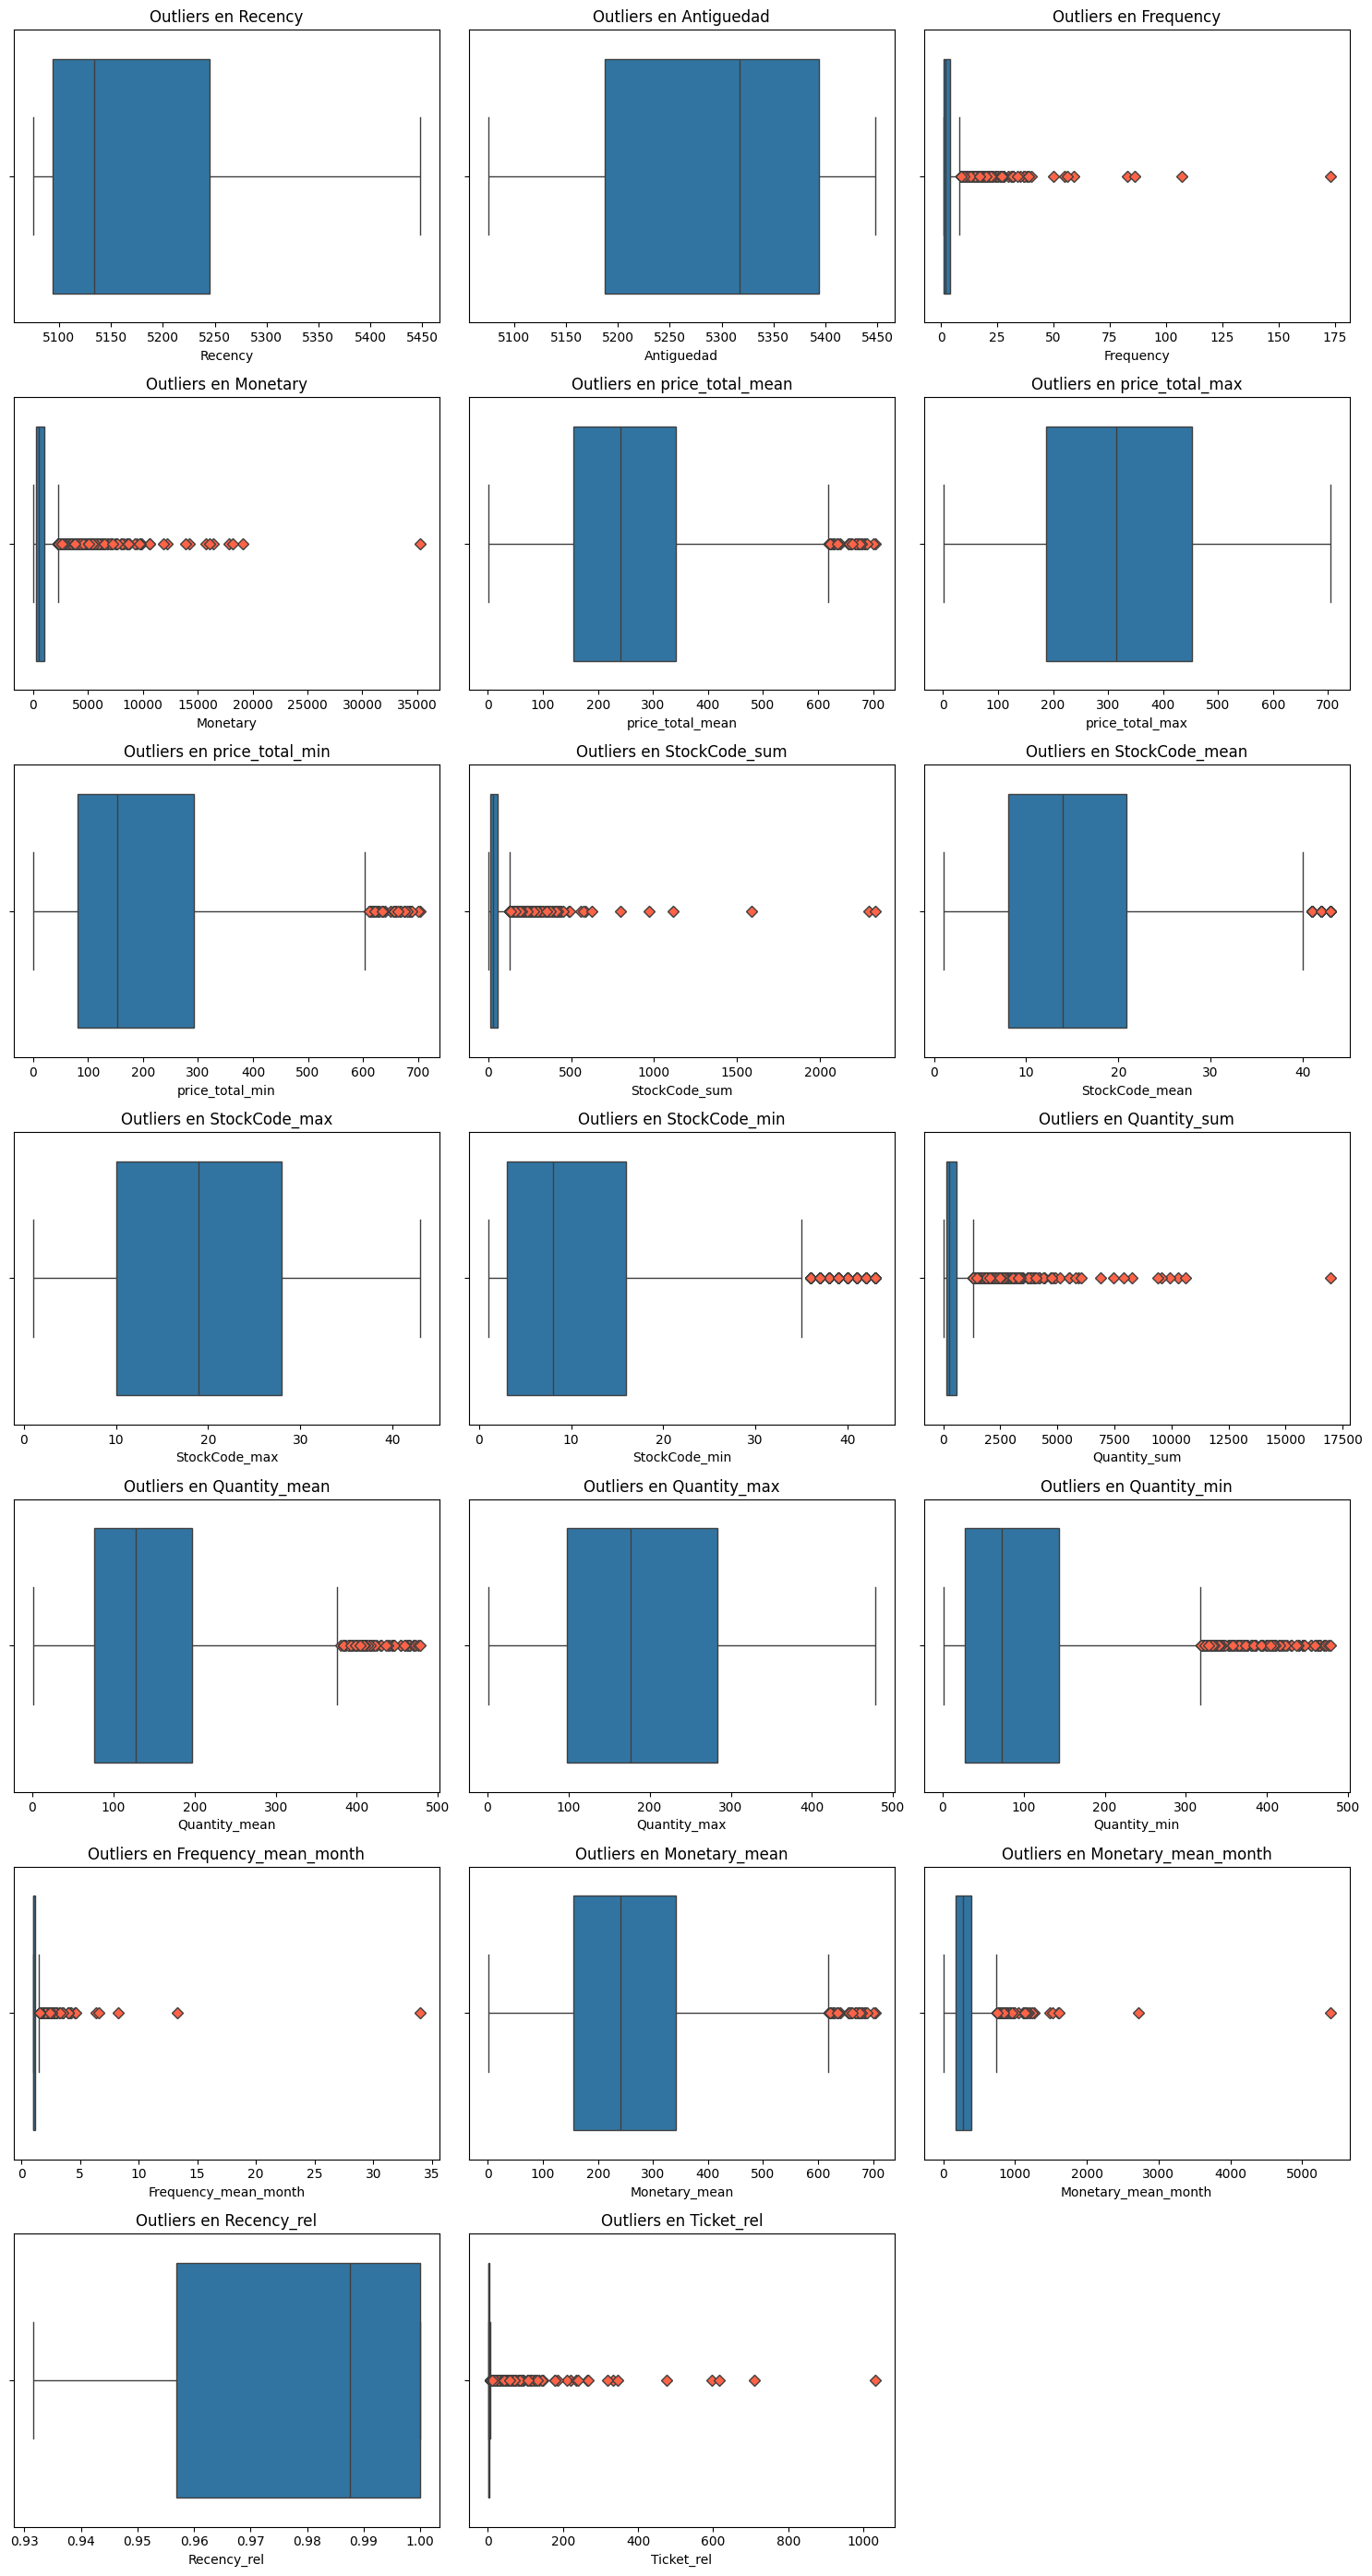

In [ ]:
variables = df_clientes.select_dtypes(include="number").columns.to_list()
plot_outliers(df_clientes, variables)

Histograma de variables

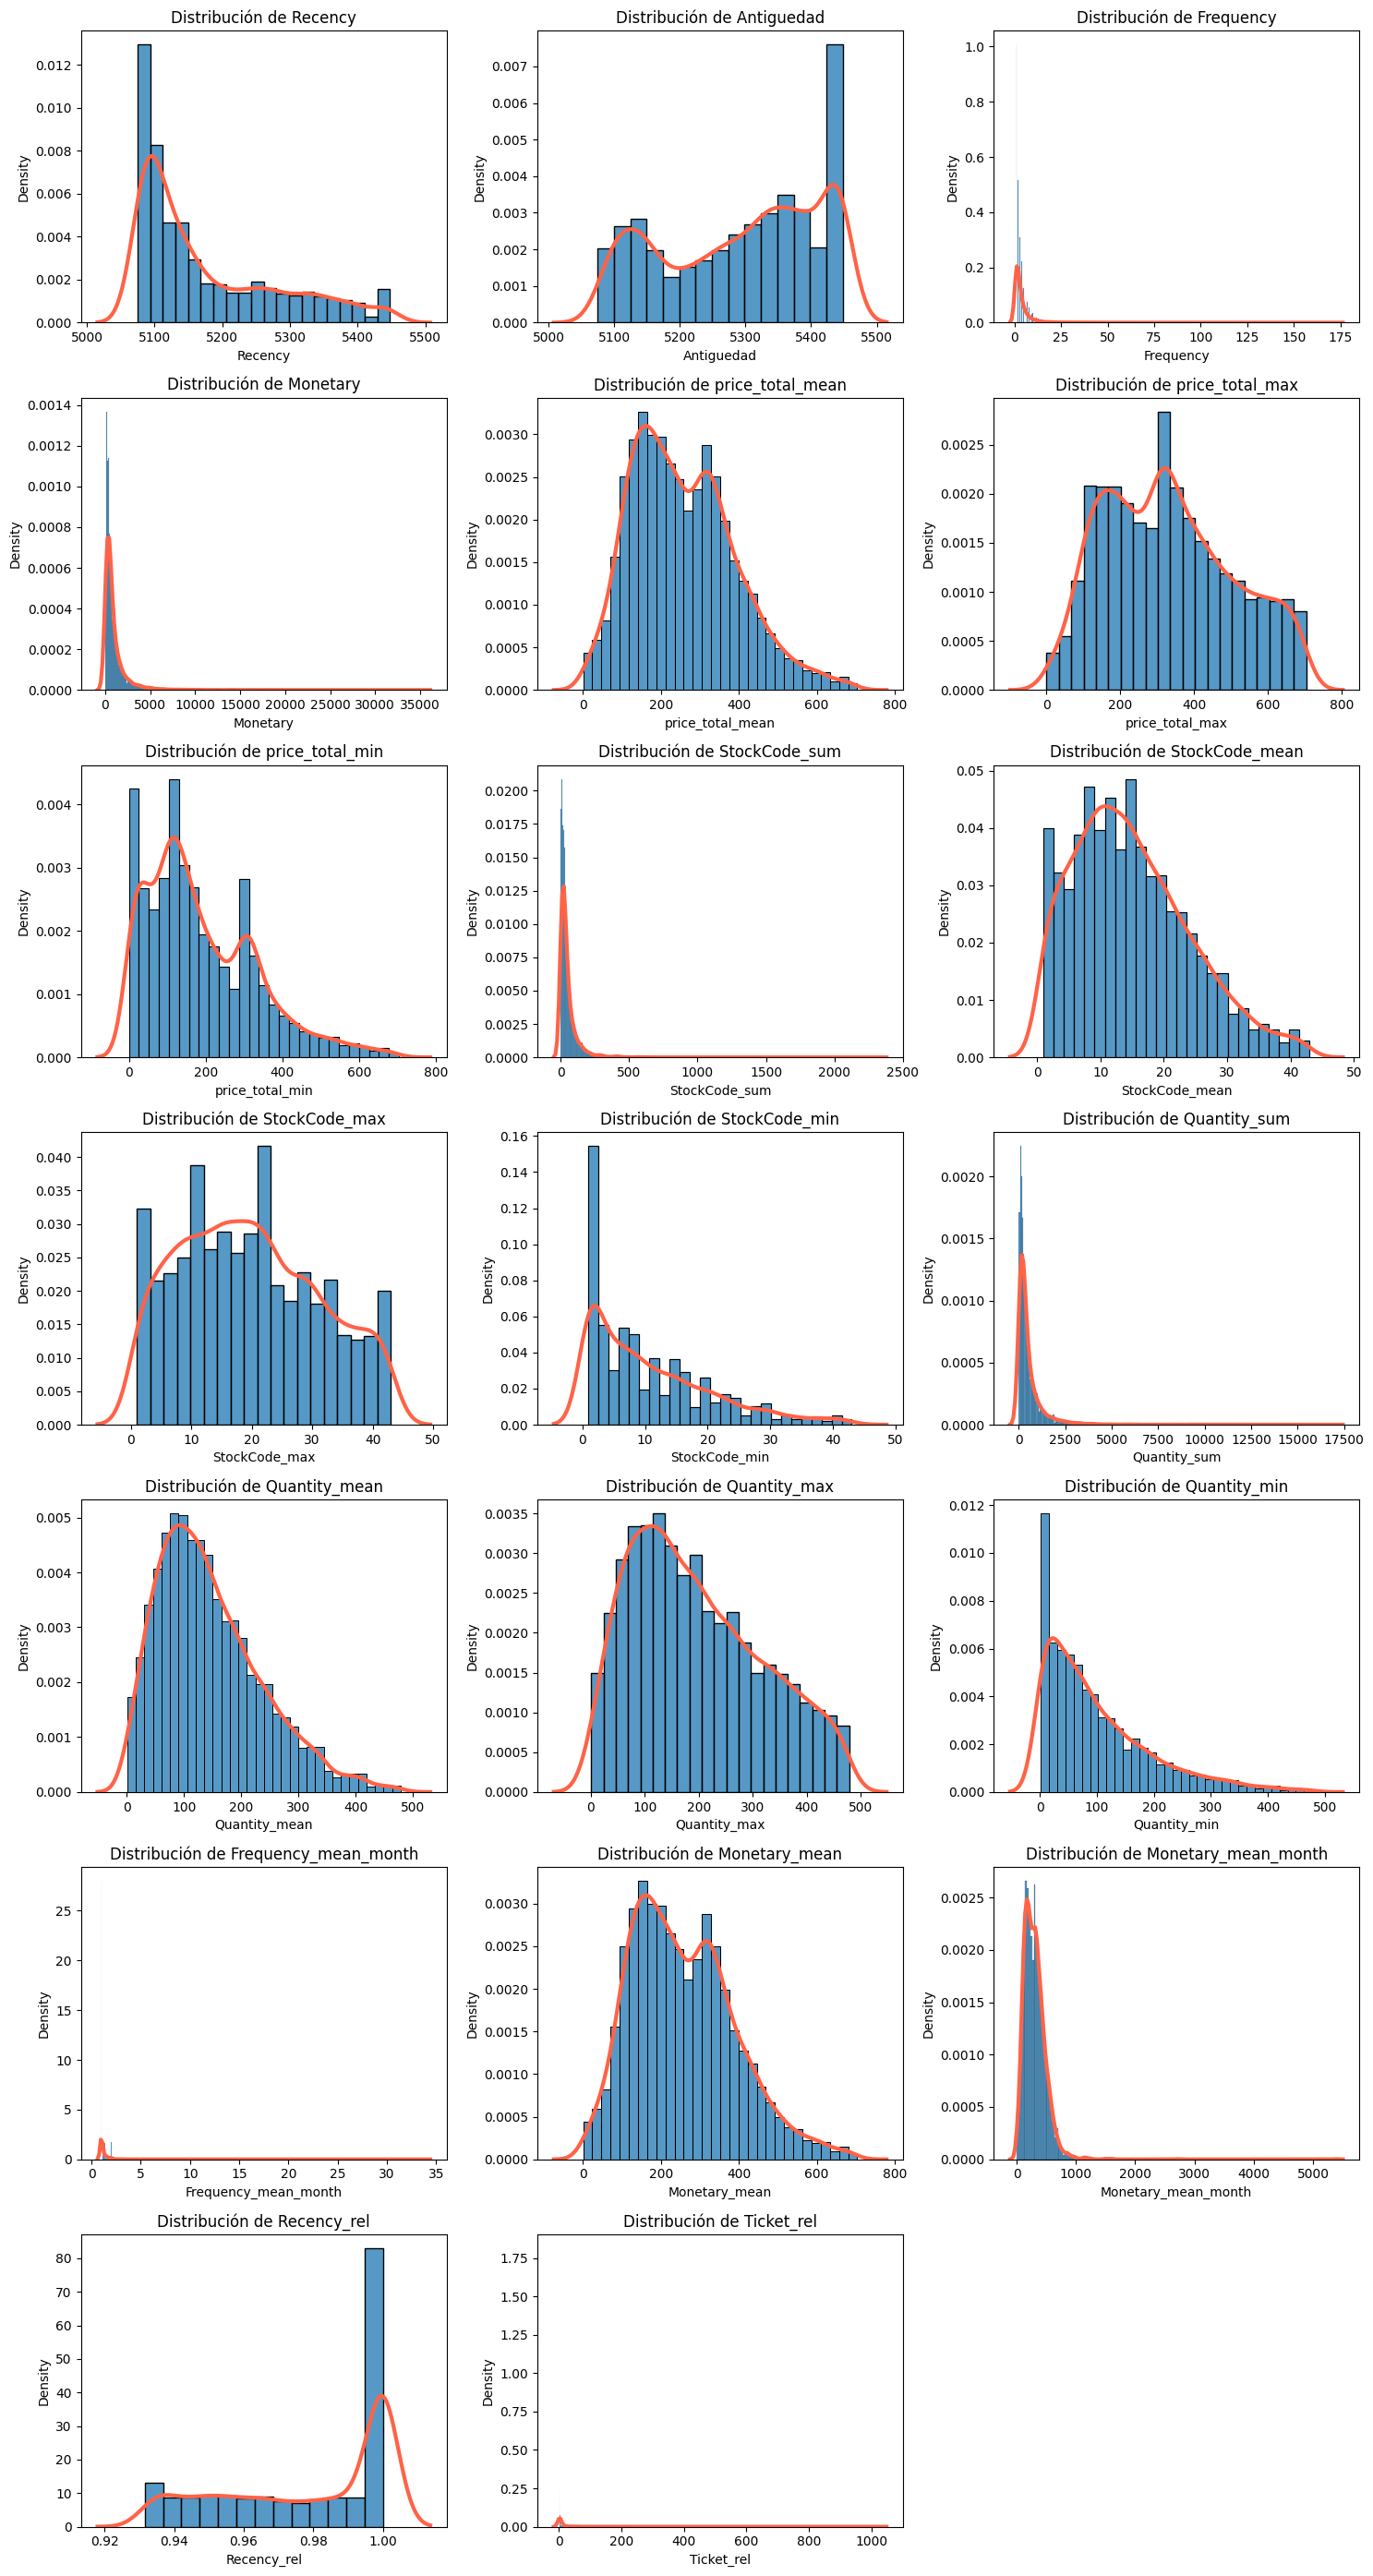

In [ ]:
plot_hist(df_clientes, variables)

In [ ]:
df_clientes = df_clientes.replace([np.inf, -np.inf], np.nan)
print(f"Número de registros nulos:\n{df_clientes.isnull().sum()}")
print(f"Número de registros NaN:\n{df_clientes.isna().sum()}")
df_clientes = df_clientes.dropna()

Número de registros nulos:
Recency                 0
Antiguedad              0
Frequency               0
Monetary                0
price_total_mean        0
price_total_max         0
price_total_min         0
StockCode_sum           0
StockCode_mean          0
StockCode_max           0
StockCode_min           0
Quantity_sum            0
Quantity_mean           0
Quantity_max            0
Quantity_min            0
Frequency_mean_month    0
Monetary_mean           0
Monetary_mean_month     0
Recency_rel             0
Ticket_rel              2
dtype: int64
Número de registros NaN:
Recency                 0
Antiguedad              0
Frequency               0
Monetary                0
price_total_mean        0
price_total_max         0
price_total_min         0
StockCode_sum           0
StockCode_mean          0
StockCode_max           0
StockCode_min           0
Quantity_sum            0
Quantity_mean           0
Quantity_max            0
Quantity_min            0
Frequency_mean_month    0

### 4. Algoritmos de clustering

Aplicar al menos 2 algoritmos de clustering. Buscar el número indicado de clusters que pueden tener y visualizar los cluster resultantes de los algoritmos.

Escalar data

In [ ]:
# Escalar de forma robusta los datos
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_clientes)

In [ ]:
# Reducir a 2 dimensiones para graficar posteriormente
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Varianza explicada (%):", np.round(pca.explained_variance_ratio_ * 100, 2))

loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=df_clientes.columns
)
print(loadings)


Varianza explicada (%): [89.19  5.67]
                       PC1   PC2
Recency              -0.00 -0.04
Antiguedad            0.00  0.03
Frequency             0.04  0.35
Monetary              0.03  0.35
price_total_mean     -0.00  0.02
price_total_max       0.01  0.06
price_total_min      -0.01 -0.03
StockCode_sum         0.03  0.30
StockCode_mean       -0.00  0.00
StockCode_max         0.00  0.04
StockCode_min        -0.01 -0.04
Quantity_sum          0.03  0.32
Quantity_mean        -0.00  0.02
Quantity_max          0.01  0.06
Quantity_min         -0.01 -0.03
Frequency_mean_month  0.04  0.72
Monetary_mean        -0.00  0.02
Monetary_mean_month   0.01  0.15
Recency_rel          -0.01 -0.06
Ticket_rel            1.00 -0.08


> Con la variable Ticket_rel es practicamente el primer componente principal y este por si solo explica más del 80% de los datos.

#### K-Means

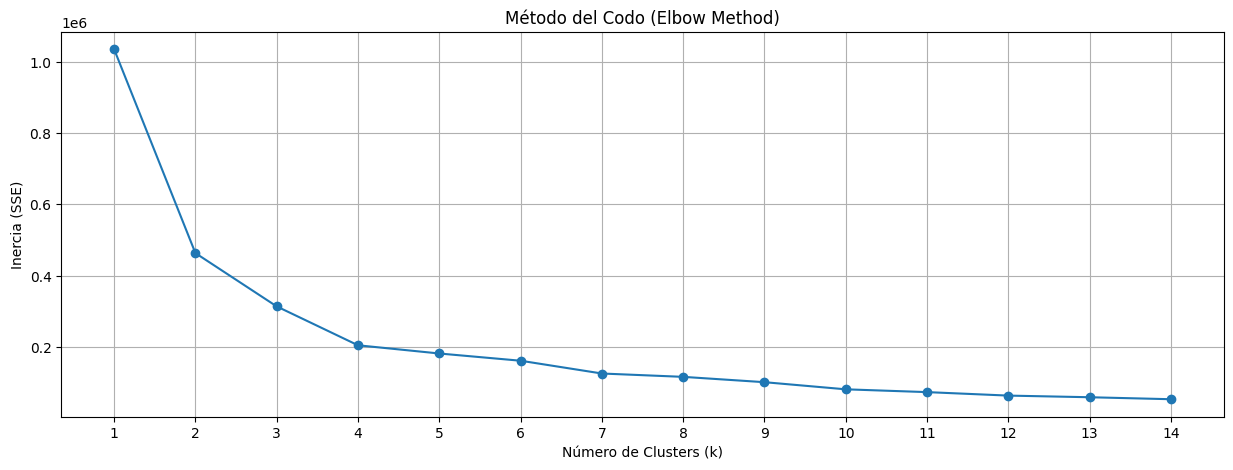

In [ ]:
sse = []
k_values = range(1, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)  # Inercia = suma de distancias cuadradas dentro de cada cluster

# Graficar método del codo
plt.figure(figsize=(15,5))
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo (Elbow Method)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (SSE)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

> Se seleccionan 2 clusteres según el método del codo

In [ ]:
k_optimo = 2
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42)
labels_kmeans = kmeans_final.fit_predict(X_scaled);
df_clientes["Cluster kmeans"] = labels_kmeans

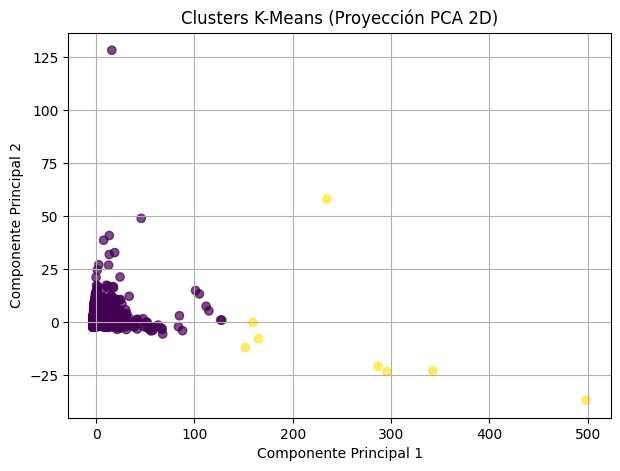

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_clientes["Cluster kmeans"], cmap="viridis", alpha=0.7)
plt.title("Clusters K-Means (Proyección PCA 2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")

# plt.xscale('log')
# plt.yscale('log')

plt.grid(True)
plt.show()

#### Fuzzy C-Means

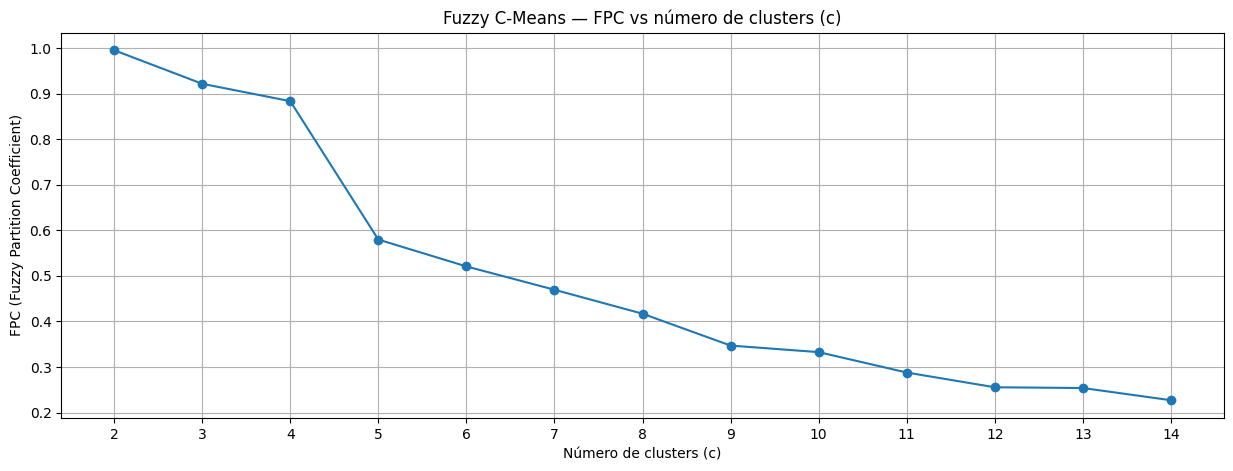

In [ ]:
X_fcm = X_scaled.T

# Probar varios números de clusters y calcular FPC
m = 2.0  # grado de difusidad (típico: 1.5–2.5)
error = 1e-5
maxiter = 500

c_values = range(2, 15)
fpc_scores = []

for c in c_values:
    cntr, u, u0, d, jm, p, fpc = cmeans(
        data=X_fcm, c=c, m=m, error=error, maxiter=maxiter, init=None
    )
    fpc_scores.append(fpc)

# Graficar "método del codo"
plt.figure(figsize=(15,5))
plt.plot(list(c_values), fpc_scores, marker='o')
plt.title('Fuzzy C-Means — FPC vs número de clusters (c)')
plt.xlabel('Número de clusters (c)')
plt.ylabel('FPC (Fuzzy Partition Coefficient)')
plt.xticks(list(c_values))
plt.grid(True)
plt.show()

In [ ]:
c_opt = 2

# Entrenar FCM final
cntr, u, u0, d, jm, p, fpc = cmeans(
    data=X_fcm, c=c_opt, m=m, error=error, maxiter=maxiter, init=None
)

labels_cmeans = u.argmax(axis=0)

df_clientes["Cluster cmeans"] = labels_cmeans

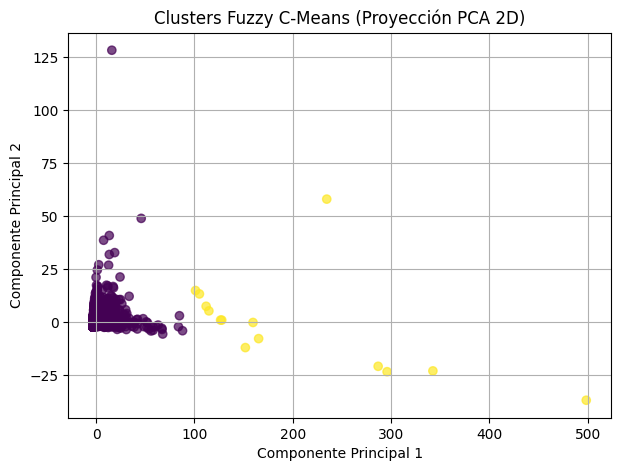

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_clientes["Cluster cmeans"], cmap="viridis", alpha=0.7)
plt.title("Clusters Fuzzy C-Means (Proyección PCA 2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")

# plt.xscale('log')
# plt.yscale('log')

plt.grid(True)
plt.show()

#### Resultados

In [ ]:
df_clientes.head()

,Recency,Antiguedad,Frequency,Monetary,price_total_mean,price_total_max,price_total_min,StockCode_sum,StockCode_mean,StockCode_max,...,Quantity_mean,Quantity_max,Quantity_min,Frequency_mean_month,Monetary_mean,Monetary_mean_month,Recency_rel,Ticket_rel,Cluster kmeans,Cluster cmeans
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,5077,5392,4,"1,667.64",416.91,584.91,224.82,80,20.00,29,...,245.00,315,192,1.00,416.91,416.91,0.94,2.60,0,0
12348,5150,5323,2,677.00,338.50,367.00,310.00,8,4.00,5,...,243.00,269,217,1.00,338.50,338.50,0.97,1.18,0,0
12350,5385,5385,1,334.40,334.40,334.40,334.40,17,17.00,17,...,197.00,197,197,1.00,334.40,334.40,1.00,1.00,0,0
12352,5111,5371,7,"1,665.74",237.96,366.25,120.33,82,11.71,18,...,76.14,127,26,1.75,237.96,416.44,0.95,3.04,0,0
12353,5279,5279,1,89.00,89.00,89.00,89.00,4,4.00,4,...,20.00,20,20,1.00,89.00,89.00,1.00,1.00,0,0


Diferendias

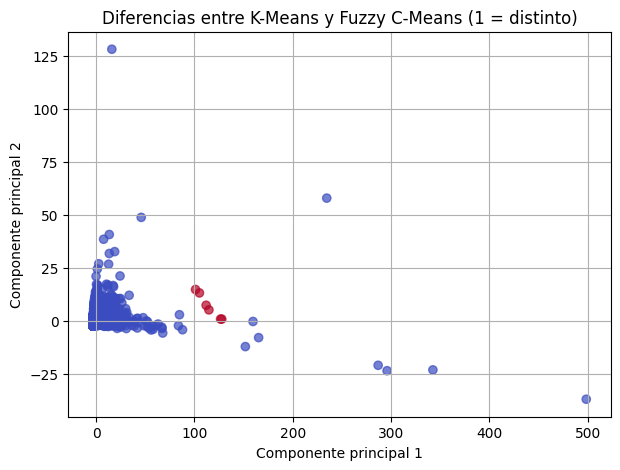

Diferencias encontradas: 6 / 3901 puntos (0.15%)


In [ ]:
diferente = (df_clientes["Cluster kmeans"] != df_clientes["Cluster cmeans"]).astype(int)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=diferente, cmap="coolwarm", alpha=0.7)
plt.title("Diferencias entre K-Means y Fuzzy C-Means (1 = distinto)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()

print(f"Diferencias encontradas: {diferente.sum()} / {len(diferente)} puntos ({diferente.mean()*100:.2f}%)")

> Diferencia entre los cluster en color rojo

### 5. Evaluación

Evaluar la calidad de los clustering de forma numérica y realizar una explicación de cada segmento asignándoles un nombre descriptivo.

In [ ]:
sse_kmeans = kmeans_final.inertia_
sse_cmeans = np.sum(np.min(d, axis=0))

silhouette_kmeans = silhouette_score(X_scaled, labels_kmeans)
silhouette_cmeans = silhouette_score(X_scaled, labels_cmeans)

dbi_kmeans = davies_bouldin_score(X_scaled, labels_kmeans)
dbi_cmeans = davies_bouldin_score(X_scaled, labels_cmeans)

resultados = pd.DataFrame({
    "Métrica": ["Silhouette", "Davies-Bouldin", "SSE"],
    "K-Means": [silhouette_kmeans, dbi_kmeans, sse_kmeans],
    "Fuzzy C-Means": [silhouette_cmeans, dbi_cmeans, sse_cmeans]
})

print("Evaluación de modelos de clustering:")
print(resultados)

Evaluación de modelos de clustering:
          Métrica    K-Means  Fuzzy C-Means
0      Silhouette       0.97           0.96
1  Davies-Bouldin       0.38           0.51
2             SSE 463,247.95      21,936.57


### Conclusiones:

- Ambos modelos presentan una buena segmentación de sus clusters (Silhoutte > 0.3). Ambos valores muy cercanos a 1, es decir, cluster bien definidos. Sin embargo, k-means es ligeramente mejor.
- En el índice Davies-Bouldin k-means tiene un mejor desempeño (mientras más bajo mejor), es decir, mejor separación y cohesión que c-means.
- En la distancia Intra Cluster (SSE) índica una mejor cohesión entre los miembros de c-means que de k-means.
- La diferencia entre ambos algoritmos de clustering en mínimo (0.15%).
- En resumen k-means presenta mejor separación entre los distintos cluster.
- Se podría generar un cluster solo usando la variable Ticket_rel la cual puede explicar más del 80% de la variabilidad de los datos (información obtenida con PCA).

---

## Conclusión FreshMart

- Se pueden generar 2 tipos de clientes a partir de la tasa de compra (Ticket_rel), es decir, la división entre el monto de la boleta más grande y el monto de la boleta más pequeña.
- Esta tasa puede servir para diferenciar entre clientes que compran mucho o poco.
- También se puede usar la frecuencia de compra por mes para diferenciar a los clientes que compran de forma recurrente de los esporádicos.
- Con estos 2 datos se pueden diferenciar 2 grupos importantes:
  - Grupo 1 (cliente VIP): Compras de montos grandes de forma recurrente (pocos clientes)
  - Grupo 2 (cliente normal): Todos los demás  

In [61]:
print(f"Porcentaje de clientes VIP (cmeans): {df_clientes['Cluster cmeans'].value_counts()[1] * 100 / len(df_clientes['Cluster cmeans']):.2f}%")
print(f"Porcentaje de clientes VIP (kmeans): {df_clientes['Cluster kmeans'].value_counts()[1] * 100 / len(df_clientes['Cluster kmeans']):.2f}%")

Porcentaje de clientes VIP (cmeans): 0.36%
Porcentaje de clientes VIP (kmeans): 0.21%


Promedios por grupos

In [56]:
df_clientes.groupby('Cluster cmeans').mean()

,Recency,Antiguedad,Frequency,Monetary,price_total_mean,price_total_max,price_total_min,StockCode_sum,StockCode_mean,StockCode_max,...,Quantity_sum,Quantity_mean,Quantity_max,Quantity_min,Frequency_mean_month,Monetary_mean,Monetary_mean_month,Recency_rel,Ticket_rel,Cluster kmeans
Cluster cmeans,,,,,,,,,,,,,,,,,,,,,
0,"5,176.99","5,293.42",3.53,925.92,257.35,330.05,189.40,50.00,15.01,19.63,...,513.18,144.96,196.12,100.37,1.18,257.35,300.90,0.98,5.56,0.00
1,"5,108.79","5,406.00",25.43,"6,627.07",238.63,539.92,1.66,311.00,12.02,28.86,...,"3,098.86",122.85,278.29,1.29,2.53,238.63,632.58,0.95,418.93,0.57
